# Midterm Exam

## General information

This is the problem description for the midterm project of the course *"Data Science for Dynamical Systems"* (Winter Term 2025/26)

Below, you will find two tasks, accompanied by two datasets.

#### IMPORTANT: out of these, you should only select **one** task as your project!

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Task 1: Unknown Ordinary Differential Equation (ODE)

This dataset contains 
* $m=200$ trajectories,
* with $N=201$ time steps each,
* with time step $dt=0.01$ (i.e., the trajectories have length $(t_0,t_e)=(0,2)$).

The data has been 
* collected from an unknown ODE with state dimension $n=2$,
* corrupted with zero-mean Gaussian noise,
* stored in a 3D array $X_\text{ode}\in\mathbb{R}^{m \times N \times n}$, meaning that the individual trajectories can be accessed using the command `X_ode[i, :, :]`.

**Task:**
* **Train a model using the dataset $X_\text{ode}$ that predicts the system behavior as accurately as possible over $N_p=100$ time steps, for arbitrary initial conditions $x_0\in[-2,2]^2$.** 
* The error should be measured as the MSE between the predicted state and the ground truh (i.e., the given data).
* You may either train a black-box model or identify the governing equations from data.


### Load and visualize dataset

In [28]:
X_ode = np.load("ODE.npy")
dt_ode, t0_ode, te_ode = 0.01, 0, 2
m, N, n = X_ode.shape

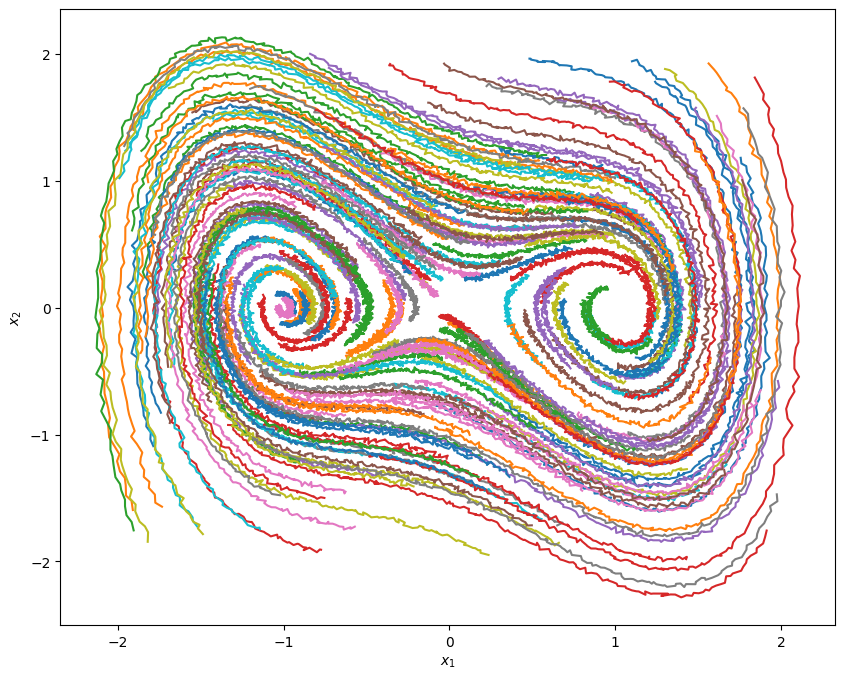

In [63]:
plt.figure(figsize=(10, 8))
for traj in X_ode:
    plt.plot(traj[:,0], traj[:,1])
    plt.xlabel(r"$x_1$")
    plt.ylabel(r"$x_2$")
plt.show()

# Task 2: The 1D Kuramoto-Sivashinsky equation

This task concerns the 1D Kuramoto-Sivashinsky equation (Wikipedia: https://en.wikipedia.org/wiki/Kuramoto%E2%80%93Sivashinsky_equation) in the following form:

$$ \frac{\partial x}{\partial t} = a\frac{\partial^4 x}{\partial s^4} + b \frac{\partial^2 x}{\partial s^2} + c x \frac{\partial x}{\partial s}, $$

where 

* $x(s,t)\in\mathbb{R}$ is the one-dimensional system state, 
* $a, b, c$ are unknown parameters, and 
* $t\geq0$ and $s\in\Omega = (0,2\pi)$ are the time and space variables, respectively. 

We consider periodic boundary conditions, i.e.,

$$ x(0, t) = x(2\pi, t) \qquad \text{for all}\quad t. $$

The dataset 
* consists of one trajectory with $N=401$ time steps
* a time step of $dt=0.1$ (note that the time step for the simulation has to be much smaller for stability reasons),
* and a spatial dimension of $n=50$ that has been obtained by discretizing $\Omega$ using finite differences. <br>
(**Note:** the final point $x(t, 2\pi)$ (which would be $x_{n+1}$) is not part of the dataset, as it is identical to $x_1$ due to periodicity; the samples are placed between $s=0$ and $s=L - \frac{L}{n}$, see also the range of $s$ below.)

The data is stored in the matrix $X_\text{ks}\in\mathbb{R}^{N \times n}$.

**Task:**
* **Train a parameter-dependent model using the dataset $X_\text{ks}$. Prediction accuracy should be measured over $N_p=100$ time steps, with initial condition $x_0$ drawn uniformly from the first 301 time steps of the dataset.** 
* The error should be measured as the MSE between the predicted state and the ground truh (i.e., the given data).
* You may either train a black-box model or identify the unknown parameters $a, b, c$ in the equation from the data.

### Load and visualize dataset

In [61]:
X_ks = np.load("KS.npy")
N_ks, n_ks = X_ks.shape
dt_ks = 0.1
L = 2*np.pi
s_range = np.linspace(0, L - L/n_ks, n_ks)

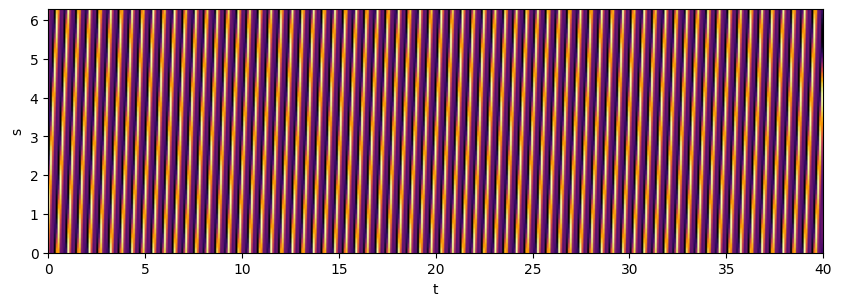

In [62]:
plt.figure(figsize=(10,8))
plt.imshow(X_ks.T, cmap="inferno", aspect=2.0, extent=[0, 40, 0, L], origin='lower')
plt.xlabel("t")
plt.ylabel("s")
plt.show()